In [1]:
from dask.distributed import Client
import dask.dataframe as dd
import dask_xgboost as dxgb
from dask_ml import datasets
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:56952 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 17.18 GB


In [3]:
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split

X, y = make_classification(n_samples=100000, n_features=20,
                           chunks=1000, n_informative=4,
                           random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [9]:
params = {
    'objective': 'binary:logistic', 
    'n_estimators': 420,
    'max_depth': 5, 
    'eta': .01,
    'subsample': 1, 
    'colsample_bytree': 1,
    'learning_rate': .05, 
    'scale_pos_weight': 1,
    'tree_method': 'exact',
    'seed': 123
}

In [10]:
bst = dxgb.train(client, params, X_train, y_train)

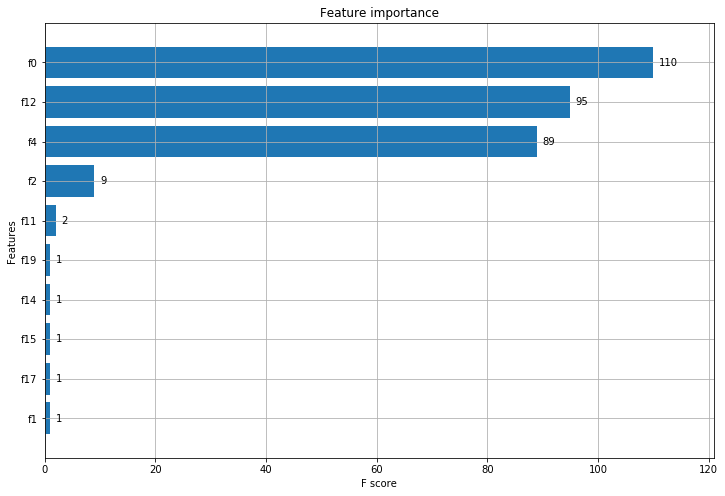

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = xgb.plot_importance(bst, ax=ax, height=0.8, max_num_features=len(X_train))
ax.grid(True, axis="y")

In [12]:
bst1 = dxgb.train(client, params, X_train, y_train)

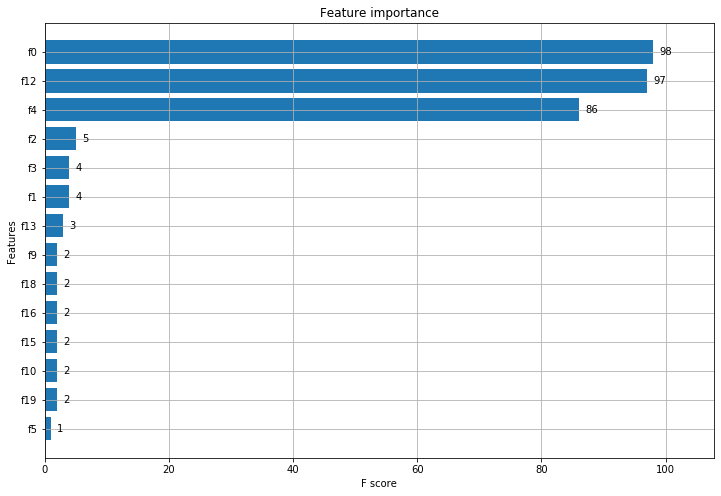

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

ax1 = xgb.plot_importance(bst1, ax=ax, height=0.8, max_num_features=len(X_train))
ax1.grid(True, axis="y")